# Project 4: CNN Image Classification

Building a Convolutional Neural Network to classify CIFAR-10 images into 10 categories. This project demonstrates why CNNs outperform MLPs on image tasks.

**Concepts Covered:**
- Convolutional layers (`nn.Conv2d`) — pattern detection with sliding filters
- Pooling layers (`nn.MaxPool2d`) — spatial downsampling
- `nn.Sequential` for clean layer grouping
- `BatchNorm2d` and `Dropout2d` for conv layers
- Data augmentation (`RandomHorizontalFlip`, `RandomCrop`, `ColorJitter`)
- GPU training with `.to(device)`
- L2 regularization (`weight_decay`)
- CNN architecture pattern: increasing filters with decreasing spatial size

In [1]:
%pip install torch torchvision
%pip install scikit-learn
%pip install numpy
%pip install matplotlib



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Device configuration — uses GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0+cu128
Using device: cuda
GPU: Tesla T4


---
## Phase 1: Load CIFAR-10 with Data Augmentation

CIFAR-10: 60,000 color images (32x32, 3 channels RGB) across 10 classes.

**Data Augmentation** — randomly modifies training images each epoch (flip, crop, color change) to create variety and prevent overfitting. Only applied to training data, never test data.

| Project 3 (MLP) | Project 4 (CNN) |
|---|---|
| Flatten image to 1D vector | Preserve 2D spatial structure |
| nn.Linear layers | nn.Conv2d + nn.MaxPool2d |
| Loses spatial information | Detects spatial patterns |
| BatchNorm1d, Dropout | BatchNorm2d, Dropout2d |

In [3]:
# Training transforms WITH augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

# Test transforms — NO augmentation, only normalize
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

# Download datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Classes: {len(class_names)}")

100%|██████████| 170M/170M [00:05<00:00, 30.6MB/s]


Train samples: 50000
Test samples: 10000
Image shape: torch.Size([3, 32, 32])
Classes: 10


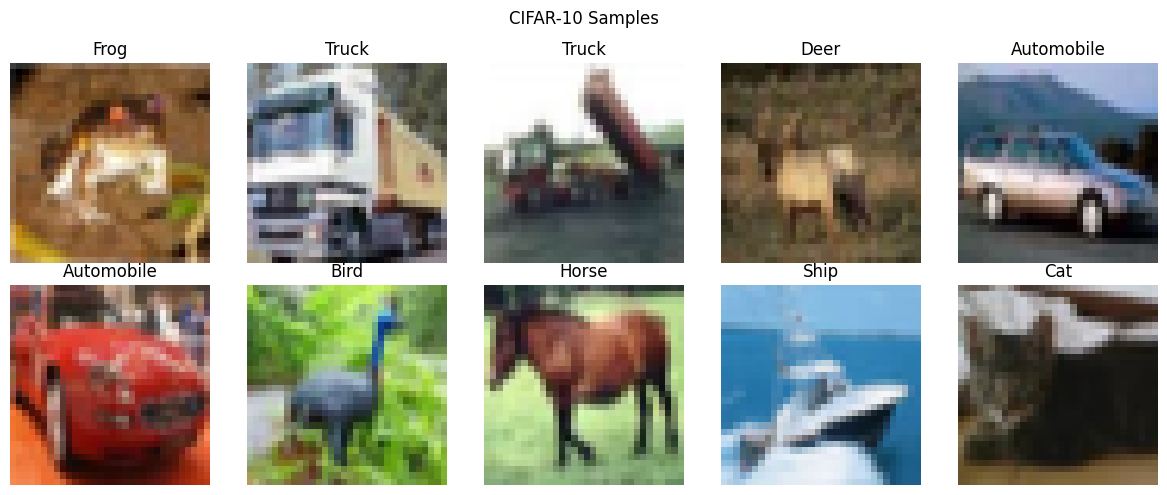

In [4]:
# Visualize sample images
display_dataset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transforms.ToTensor())
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image, label = display_dataset[i]
    ax.imshow(image.permute(1, 2, 0))    # (C, H, W) → (H, W, C) for matplotlib
    ax.set_title(class_names[label])
    ax.axis('off')
plt.suptitle("CIFAR-10 Samples")
plt.tight_layout()
plt.show()

---
## Phase 2: Define CNN Model

### CNN Architecture Pattern
```
Conv Block = Conv2d → BatchNorm2d → ReLU → Conv2d → BatchNorm2d → ReLU → MaxPool → Dropout2d

Block 1: (3, 32, 32)   → (32, 16, 16)    few filters, big image
Block 2: (32, 16, 16)  → (64, 8, 8)      more filters, smaller image
Block 3: (64, 8, 8)    → (128, 4, 4)     most filters, smallest image
Then:    Flatten → Linear(2048, 256) → Linear(256, 10)
```

**Key insight:** Images get smaller spatially but richer in features as they flow deeper.

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers — feature extraction
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),    # 3 input channels (RGB), 32 filters
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                                # 32x32 → 16x16
            nn.Dropout2d(0.25)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                                # 16x16 → 8x8
            nn.Dropout2d(0.25)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                                # 8x8 → 4x4
            nn.Dropout2d(0.25)
        )

        # Classifier — fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),                                   # 128 * 4 * 4 = 2048
            nn.Linear(128 * 4 * 4, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)                              # 10 classes
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x

model = CNN().to(device)    # Move model to GPU
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

CNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

In [6]:
# Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # weight_decay = L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5
)

In [7]:
# Training loop
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
best_test_acc = 0.0
patience_counter = 0
patience_limit = 15

num_epochs = 50

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move to GPU

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # --- Evaluation ---
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move to GPU

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            running_test_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += batch_y.size(0)
            correct_test += (predicted == batch_y).sum().item()

    test_loss = running_test_loss / total_test
    test_acc = correct_test / total_test

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    scheduler.step(test_loss)

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_cnn_model.pth")
    else:
        patience_counter += 1

    if epoch % 5 == 0:
        print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    if patience_counter >= patience_limit:
        print(f"\nEarly stopping at epoch {epoch}!")
        break

print(f"\nBest Test Accuracy: {best_test_acc:.4f}")

Epoch  0 | Train Loss: 1.7097 | Test Loss: 1.2458 | Train Acc: 0.3716 | Test Acc: 0.5427
Epoch  5 | Train Loss: 0.9328 | Test Loss: 0.6840 | Train Acc: 0.6747 | Test Acc: 0.7657
Epoch 10 | Train Loss: 0.7726 | Test Loss: 0.6009 | Train Acc: 0.7358 | Test Acc: 0.7969
Epoch 15 | Train Loss: 0.7082 | Test Loss: 0.5293 | Train Acc: 0.7588 | Test Acc: 0.8182
Epoch 20 | Train Loss: 0.6629 | Test Loss: 0.5145 | Train Acc: 0.7731 | Test Acc: 0.8229
Epoch 25 | Train Loss: 0.6354 | Test Loss: 0.4638 | Train Acc: 0.7832 | Test Acc: 0.8436
Epoch 30 | Train Loss: 0.6052 | Test Loss: 0.4514 | Train Acc: 0.7932 | Test Acc: 0.8465
Epoch 35 | Train Loss: 0.5927 | Test Loss: 0.4319 | Train Acc: 0.8005 | Test Acc: 0.8526
Epoch 40 | Train Loss: 0.5790 | Test Loss: 0.4569 | Train Acc: 0.8029 | Test Acc: 0.8468
Epoch 45 | Train Loss: 0.5163 | Test Loss: 0.3954 | Train Acc: 0.8243 | Test Acc: 0.8684

Best Test Accuracy: 0.8707


---
## Phase 3: Detailed Evaluation

In [8]:
# Load best model and evaluate
model.load_state_dict(torch.load("best_cnn_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())    # move back to CPU for sklearn
        all_labels.extend(batch_y.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

    Airplane       0.86      0.89      0.87      1000
  Automobile       0.95      0.94      0.94      1000
        Bird       0.89      0.77      0.82      1000
         Cat       0.81      0.68      0.74      1000
        Deer       0.86      0.88      0.87      1000
         Dog       0.76      0.85      0.81      1000
        Frog       0.86      0.93      0.89      1000
       Horse       0.92      0.91      0.91      1000
        Ship       0.91      0.92      0.91      1000
       Truck       0.89      0.95      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



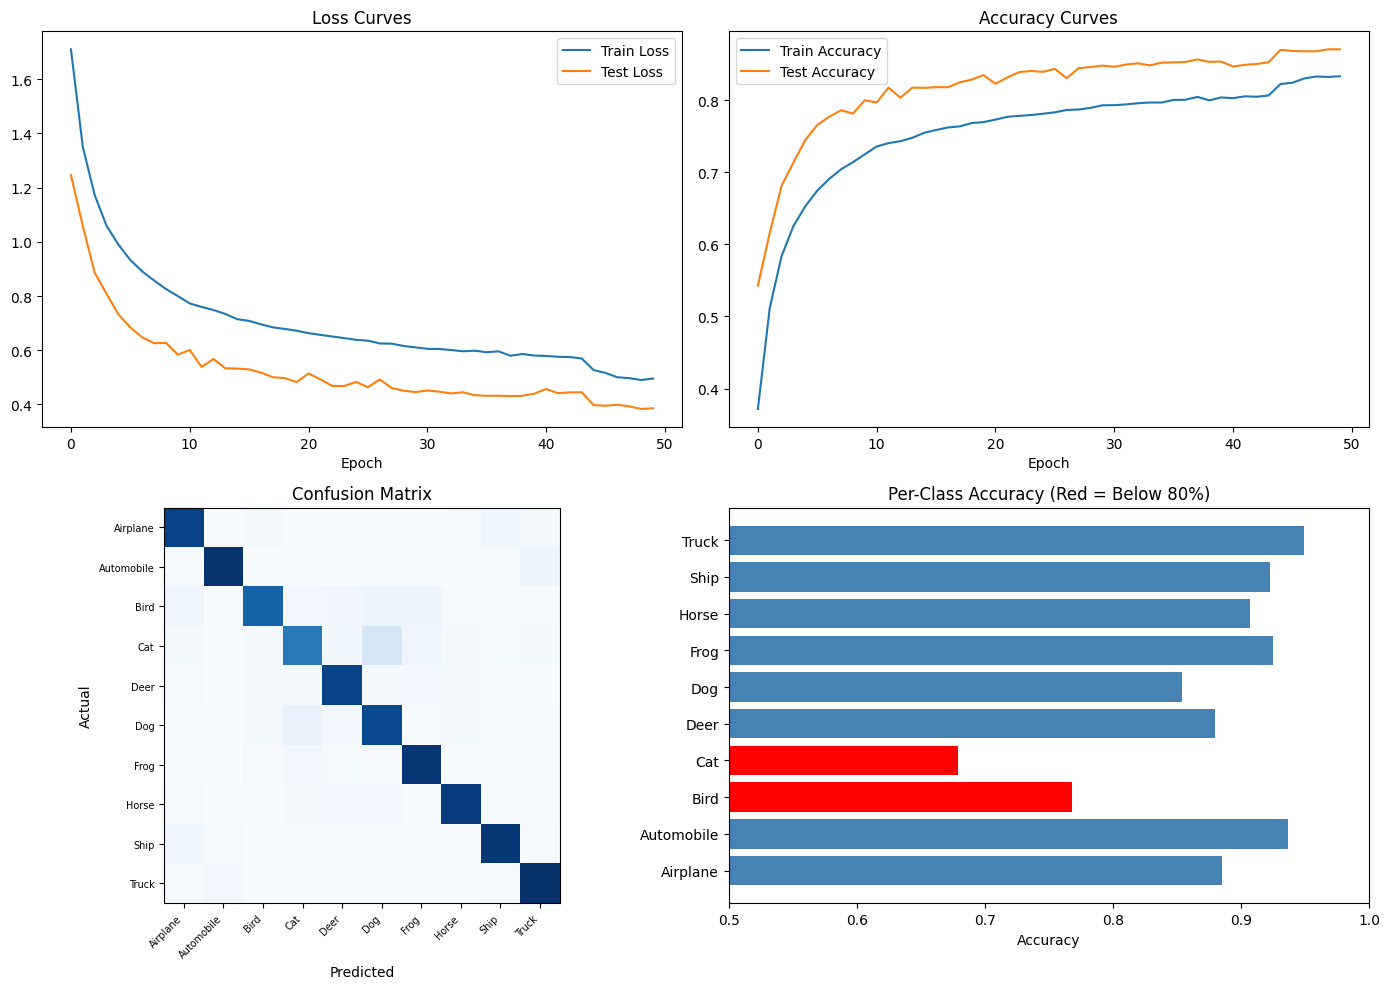

In [9]:
# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0][0].plot(train_losses, label="Train Loss")
axes[0][0].plot(test_losses, label="Test Loss")
axes[0][0].set_title("Loss Curves")
axes[0][0].set_xlabel("Epoch")
axes[0][0].legend()

# Accuracy curves
axes[0][1].plot(train_accuracies, label="Train Accuracy")
axes[0][1].plot(test_accuracies, label="Test Accuracy")
axes[0][1].set_title("Accuracy Curves")
axes[0][1].set_xlabel("Epoch")
axes[0][1].legend()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
im = axes[1][0].imshow(cm, cmap="Blues")
axes[1][0].set_xticks(range(10))
axes[1][0].set_yticks(range(10))
axes[1][0].set_xticklabels(class_names, rotation=45, ha="right", fontsize=7)
axes[1][0].set_yticklabels(class_names, fontsize=7)
axes[1][0].set_xlabel("Predicted")
axes[1][0].set_ylabel("Actual")
axes[1][0].set_title("Confusion Matrix")

# Per-class accuracy
class_accs = []
for i in range(10):
    class_mask = np.array(all_labels) == i
    class_acc = (np.array(all_preds)[class_mask] == i).mean()
    class_accs.append(class_acc)

colors = ['red' if acc < 0.80 else 'steelblue' for acc in class_accs]
axes[1][1].barh(class_names, class_accs, color=colors)
axes[1][1].set_xlabel("Accuracy")
axes[1][1].set_title("Per-Class Accuracy (Red = Below 80%)")
axes[1][1].set_xlim(0.5, 1.0)

plt.tight_layout()
plt.show()

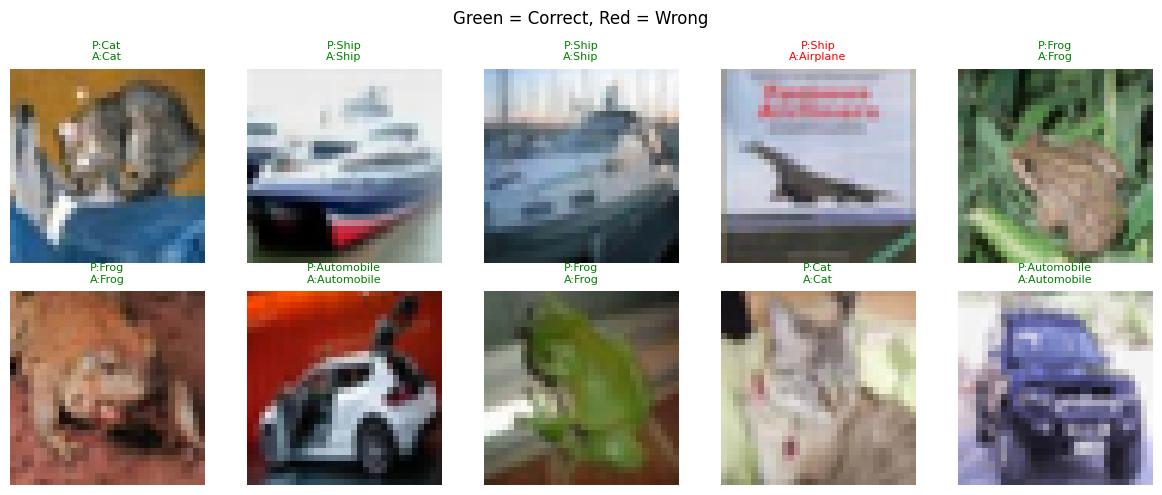

In [10]:
# Sample predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image, label = test_dataset[i]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
    # Denormalize for display
    img_display = image.permute(1, 2, 0).numpy()
    img_display = img_display * np.array([0.2470, 0.2435, 0.2616]) + np.array([0.4914, 0.4822, 0.4465])
    img_display = np.clip(img_display, 0, 1)
    ax.imshow(img_display)
    color = 'green' if pred.item() == label else 'red'
    ax.set_title(f"P:{class_names[pred.item()]}\nA:{class_names[label]}", color=color, fontsize=8)
    ax.axis('off')
plt.suptitle("Green = Correct, Red = Wrong")
plt.tight_layout()
plt.show()

In [11]:
# Per-class accuracy printout
print("Per-Class Accuracy:")
for i, name in enumerate(class_names):
    print(f"  {name:12s}: {class_accs[i]:.4f}")

Per-Class Accuracy:
  Airplane    : 0.8850
  Automobile  : 0.9370
  Bird        : 0.7680
  Cat         : 0.6790
  Deer        : 0.8800
  Dog         : 0.8540
  Frog        : 0.9250
  Horse       : 0.9070
  Ship        : 0.9230
  Truck       : 0.9490


In [12]:
# Save model
print("Best model saved as best_cnn_model.pth")

Best model saved as best_cnn_model.pth


---
## Key Takeaways

### CNN Architecture
```
Image → [Conv → BN → ReLU → Conv → BN → ReLU → Pool → Dropout] × 3 → Flatten → Linear → Output
         32 filters           64 filters          128 filters
         32×32 → 16×16       16×16 → 8×8         8×8 → 4×4
```

### Concepts Learned
1. **Conv2d** — slides filters across image to detect patterns (edges → textures → shapes)
2. **MaxPool2d** — downsamples feature maps, reduces computation
3. **Data Augmentation** — randomly modifies training images for better generalization
4. **GPU Training** — `.to(device)` for model and data, massive speed improvement
5. **nn.Sequential** — clean way to group layers into blocks
6. **BatchNorm2d/Dropout2d** — 2D versions for convolutional layers
7. **weight_decay** — L2 regularization built into optimizer
8. **`.cpu().numpy()`** — move GPU tensors back to CPU for sklearn/matplotlib

### Why CNN > MLP for Images
- MLP flattens images → loses spatial relationships between pixels
- CNN preserves 2D structure → detects spatial patterns (edges, shapes)
- CNN uses weight sharing (same filter slides everywhere) → far fewer parameters
- CNN builds hierarchical features: edges → textures → parts → objects

### GPU Training Key Rule
- Model and data must be on the **same device**
- `model.to(device)` — move model once
- `batch_X.to(device)` — move each batch inside the loop
- `.cpu().numpy()` — move back to CPU for non-PyTorch operations

### Test Your Knowledge
- How convolution works (filter sliding, feature maps)
- Why filters increase deeper in the network (more complex patterns)
- Role of MaxPooling (downsample, not pattern detection)
- Data augmentation: why only on training data
- CNN vs MLP trade-offs for image tasks
- GPU training workflow and device management